<a href="https://colab.research.google.com/github/Bala534/WIDS-Datathon-2021/blob/main/WIDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [87]:
!pip install octopus-ml

In [88]:
!pip install pandas-summary

In [89]:
import warnings
warnings.simplefilter("ignore")
import seaborn as sns 
import matplotlib.pyplot as plt
import time
import pandas as pd
import numpy as np
import lightgbm as lgb
import tracemalloc
from pandas_summary import DataFrameSummary
from sklearn.metrics import classification_report
%matplotlib inline
sns.set_style("whitegrid")

pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', -1)  # or 199

#check out https://github.com/gershonc/octopus-ml
import octopus_ml as oc

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

**Load the datasets**

In [90]:
train_df = pd.read_csv ( "TrainingWiDS2021.csv")
test_df = pd.read_csv("UnlabeledWiDS2021.csv")
data_dict = pd.read_csv ( "DataDictionaryWiDS2021.csv")

**EDA**

In [91]:
print ("Train set: ",train_df.shape)
print ("Test set: ",test_df.shape)

Train set:  (130157, 181)
Test set:  (10234, 180)


In [92]:
dfs = DataFrameSummary(train_df)
dfs.summary()

,Unnamed: 0,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
count,130157,130157,130157,125169,125667,130157,NaN,NaN,128080,NaN,NaN,130157,NaN,NaN,130157,130157,126694,51994,128472,129292,130157,130157,47597,104746,105275,30437,127967,127967,129448,127967,115461,129848,103399,130157,129737,30437,30437,30437,30437,129349,105638,123546,66990,130157,100682,35089,35089,129880,129880,128521,128521,129895,129895,35289,35289,129830,129830,127929,127929,129474,129474,129625,129625,35119,35119,129886,129886,128534,128534,125663,125663,25328,25328,124630,124630,118818,118818,126083,126083,25391,25391,123627,123627,116860,116860,123703,123703,123915,123915,25350,25350,124638,124638,118827,118827,100454,100454,58751,58751,53422,53422,116423,116423,113465,113465,116884,116884,121914,121914,110110,110110,113925,113925,114569,114569,48944,48944,34654,34654,111600,111600,117611,117611,116887,116887,112728,112728,11152,11152,10296,10296,25167,25167,24236,24236,25373,25373,55084,55084,23762,23762,27367,27367,27201,27201,48944,48944,11690,11690,24428,24428,29336,29336,28376,28376,24171,24171,45696,45696,45350,45350,46147,46147,36818,36818,22491,22491,22308,

In [93]:
data_dict[data_dict['Variable Name']=='icu_id']

,Category,Variable Name,Unit of Measure,Data Type,Description,Example
11,demographic,icu_id,None,integer,A unique identifier for the unit to which the patient was admitted,None


**Mimissing data analysis**

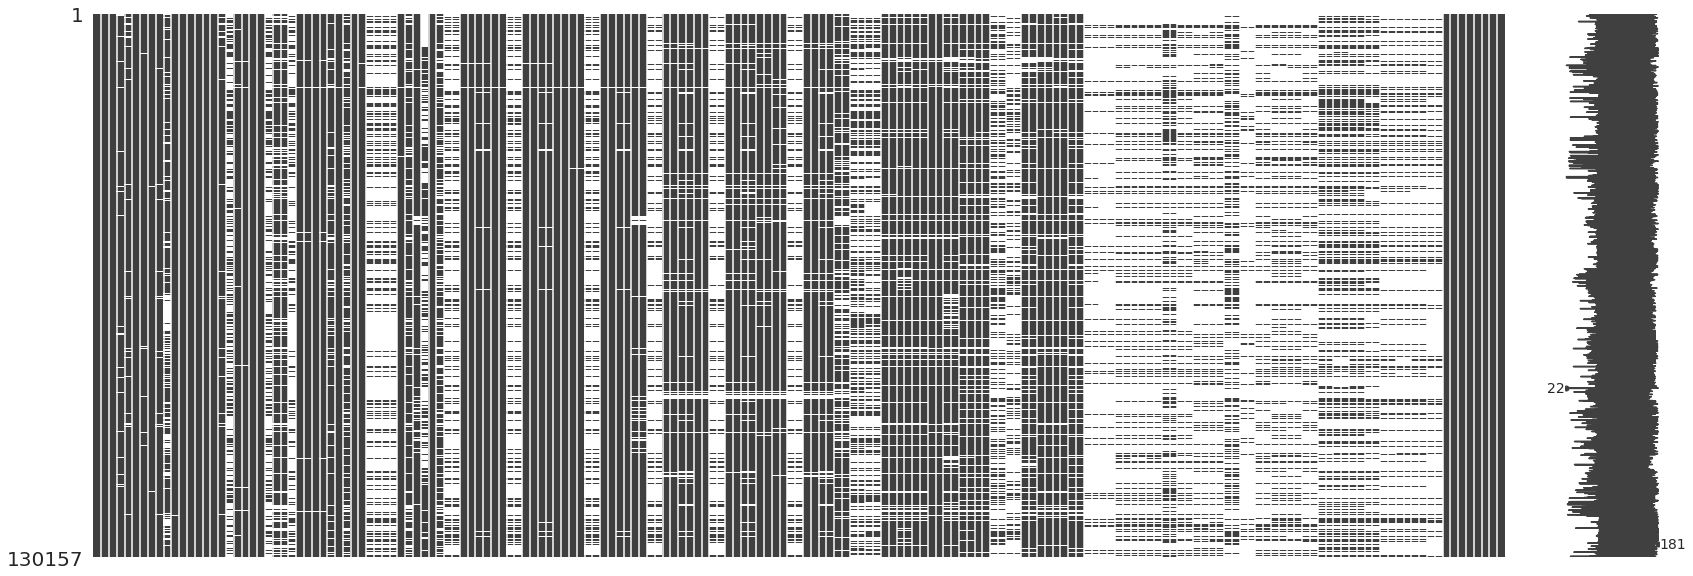

In [94]:
import missingno as msno
msno.matrix(train_df)

In [95]:
pd.Series(1 - train_df.count() / len(train_df)).sort_values(ascending=False).head(20)

h1_bilirubin_min        0.920896
h1_bilirubin_max        0.920896
h1_albumin_min          0.914319
h1_albumin_max          0.914319
h1_lactate_max          0.910185
h1_lactate_min          0.910185
h1_pao2fio2ratio_min    0.871232
h1_pao2fio2ratio_max    0.871232
h1_arterial_ph_min      0.828607
h1_arterial_ph_max      0.828607
h1_arterial_pco2_max    0.827201
h1_arterial_pco2_min    0.827201
h1_arterial_po2_min     0.825503
h1_arterial_po2_max     0.825503
h1_hco3_min             0.817436
h1_hco3_max             0.817436
h1_wbc_max              0.814294
h1_wbc_min              0.814294
h1_calcium_max          0.813794
h1_calcium_min          0.813794
dtype: float64

In [96]:
categorical_features=[]
for c in train_df.columns:
    col_type = train_df[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        train_df[c] = train_df[c].astype('category')
        categorical_features.append(c)
print (categorical_features)

['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'icu_type']


<Figure size 216x288 with 0 Axes>

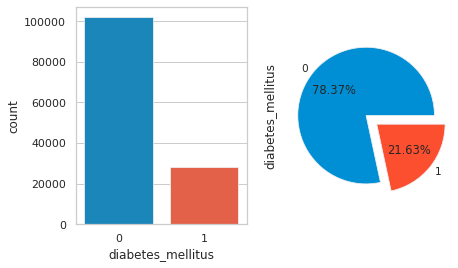

<Figure size 216x288 with 0 Axes>

In [97]:
fig, ax =plt.subplots(1,2)


plt.style.use('fivethirtyeight')
plt.figure(figsize=(3,4))
sns.set_context("paper", font_scale=1.2)                                                  
sns.countplot('diabetes_mellitus',data=train_df, ax=ax[0])
train_df['diabetes_mellitus'].value_counts().plot.pie(explode=[0,0.2],autopct='%1.2f%%',ax=ax[1])
fig.show()

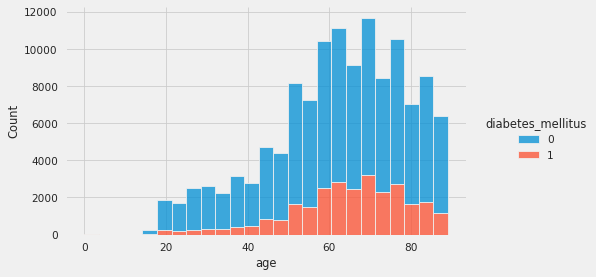

In [98]:
sns.displot(data = train_df, kind = 'hist', x = 'age', hue = 'diabetes_mellitus', multiple = 'stack',bins=25,height = 4, aspect = 1.7)

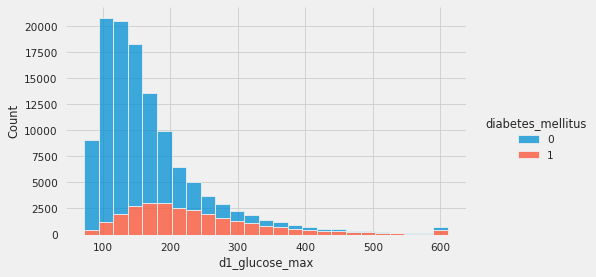

In [99]:
sns.displot(data = train_df, kind = 'hist', x = 'd1_glucose_max', hue = 'diabetes_mellitus', multiple = 'stack',bins=25,height = 4, aspect = 1.7)

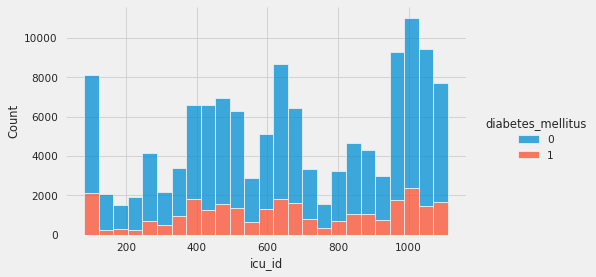

In [100]:
sns.displot(data = train_df, kind = 'hist', x = 'icu_id', hue = 'diabetes_mellitus', multiple = 'stack',bins=25,height = 4, aspect = 1.7)

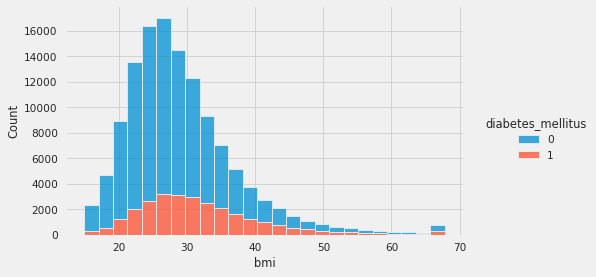

In [101]:
sns.displot(data = train_df, kind = 'hist', x = 'bmi', hue = 'diabetes_mellitus', multiple = 'stack',bins=25,height = 4, aspect = 1.7)

<Figure size 216x288 with 0 Axes>

<Figure size 216x288 with 0 Axes>

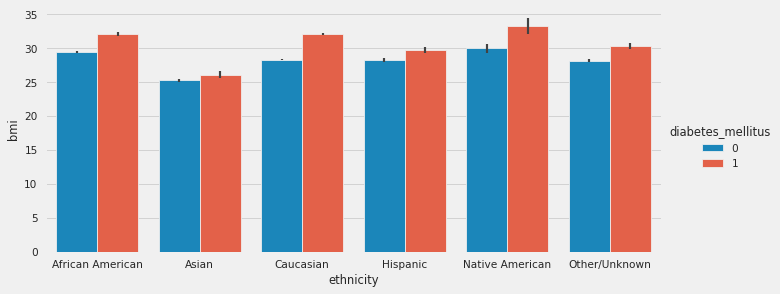

In [102]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(3,4))
sns.set_context("paper", font_scale=1.2)   
sns.factorplot(x="ethnicity", y="bmi", hue="diabetes_mellitus", data=train_df, kind="bar",height = 4, aspect = 2.3)

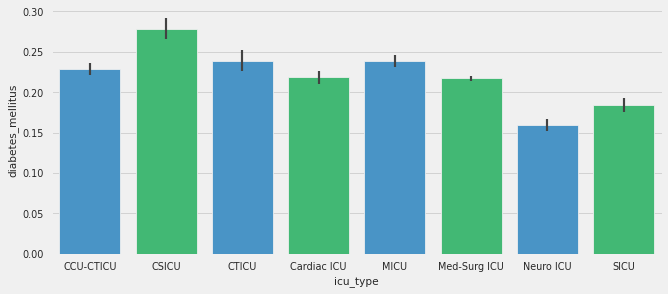

In [103]:
plt.style.use('fivethirtyeight')
sns.set_context("paper", font_scale=1.1)   
gcbest = ["#3498db", "#2ecc71"]
sns.set_palette(gcbest,20)
sns.factorplot(x="icu_type", y="diabetes_mellitus", data=train_df, kind="bar",height = 4, aspect = 2.3)

In [104]:
features=train_df.columns.to_list()
print ('Number of features ', len(features))

Number of features  181


In [105]:
features_remove=['Unnamed: 0','encounter_id','diabetes_mellitus']
for f in features_remove:
    features.remove(f)

In [106]:
X=train_df[features]
y=train_df['diabetes_mellitus']

In [107]:
train_df = train_df.replace(to_replace=np.NaN,value=np.mean(train_df))

**Model Training (LightGBM)**

In [108]:
params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'learning_rate': 0.007,
        'subsample': 1,
        'colsample_bytree': 0.2,
        'reg_alpha': 3,
        'reg_lambda': 1,
        'scale_pos_weight': 4,
        'n_estimators': 10000,
        'verbose': 1,
        'max_depth': -1,
        'seed':100, 
        'force_col_wise': True

}

clf,arr_f1_weighted,arr_f1_macro,arr_f1_positive,prediction_folds,preds_folds,y_folds= oc.cv(X,y,0.5,16000,shuffle=True,params=params)

5it [23:44, 284.94s/it]

Method Name       : cv
Current memory usage: 6.744934MB
Peak                : 636.311659MB
Total time taken:   1424735.747 ms 


**Model evaluation**

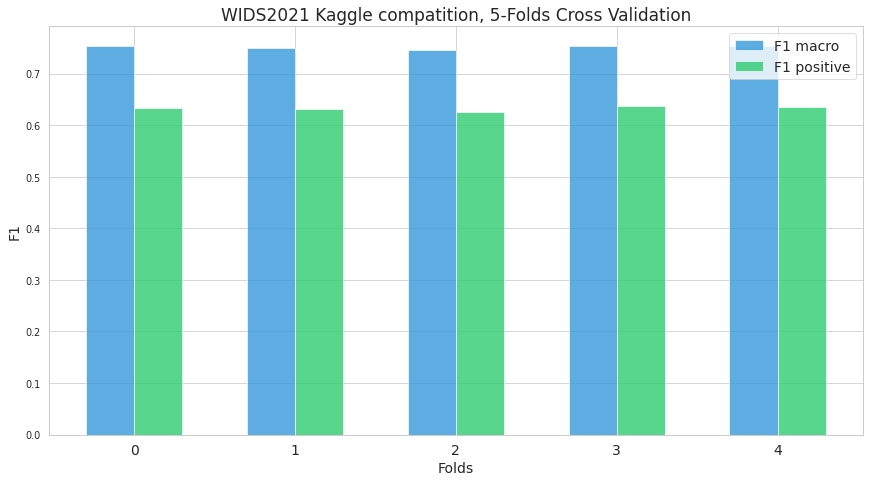

In [109]:
oc.cv_plot(arr_f1_weighted,arr_f1_macro,arr_f1_positive,'WIDS2021 Kaggle compatition')

In [110]:
print(classification_report(y_folds, prediction_folds))

              precision    recall  f1-score   support

           0       0.93      0.82      0.87    102006
           1       0.54      0.77      0.63     28151

    accuracy                           0.81    130157
   macro avg       0.73      0.79      0.75    130157
weighted avg       0.84      0.81      0.82    130157



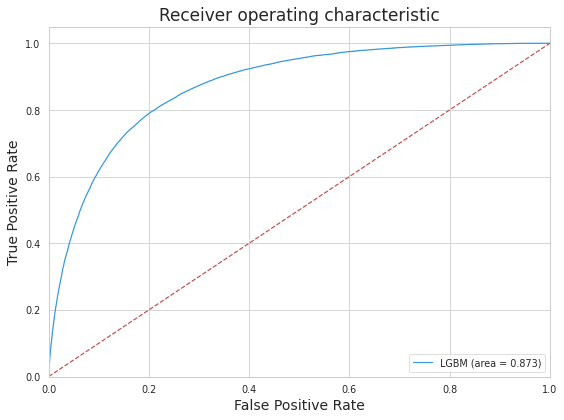

In [111]:
oc.roc_curve_plot(y_folds,preds_folds)

<Figure size 432x288 with 0 Axes>

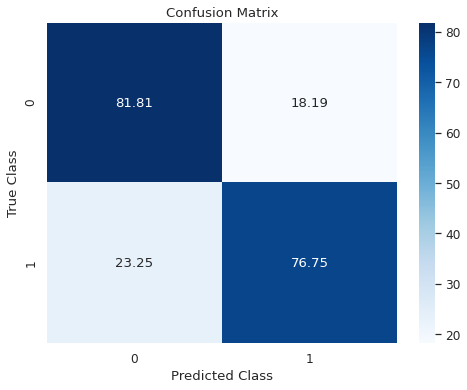

<Figure size 432x288 with 0 Axes>

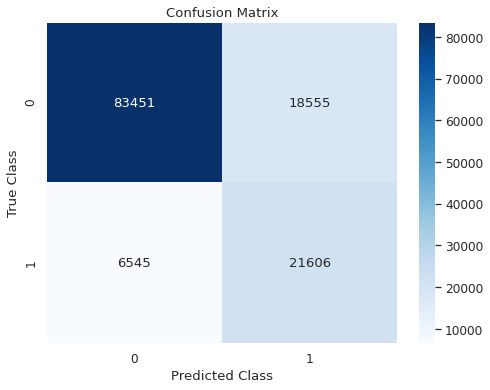

In [112]:
oc.confusion_matrix_plot(y_folds,prediction_folds)

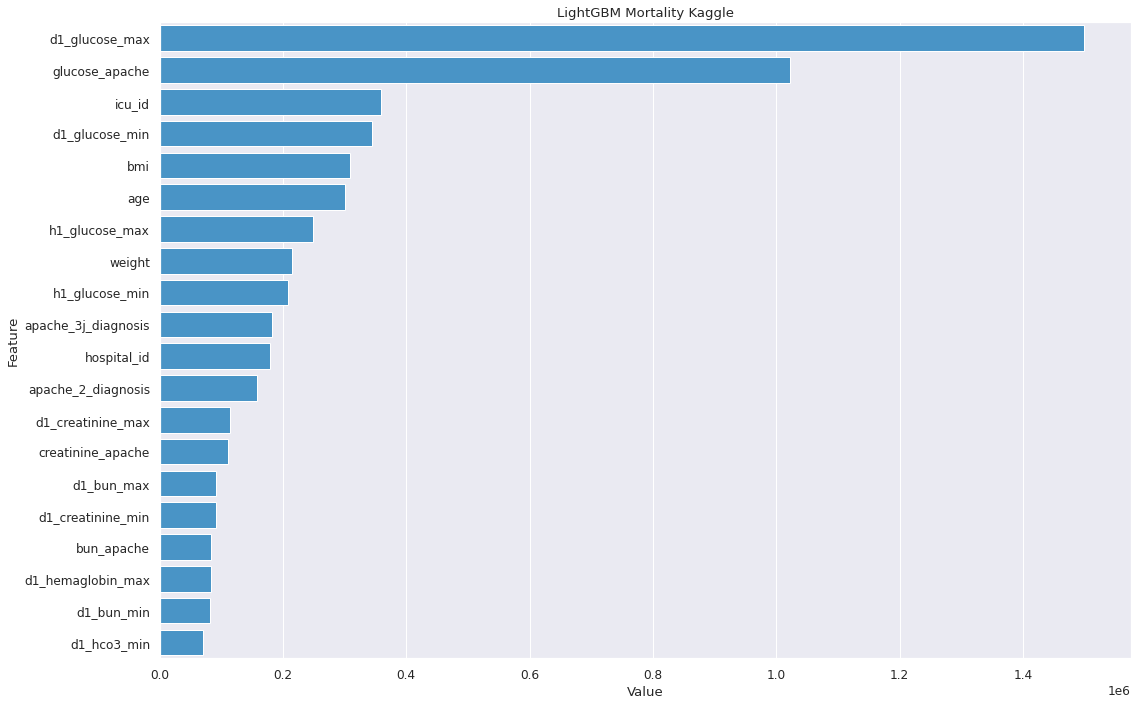

In [113]:
feature_imp_list=oc.plot_imp(clf,X,'LightGBM Mortality Kaggle',num=20)

In [114]:
top_features=feature_imp_list.sort_values(by='Value', ascending=False).head(20)
top_features

,Value,Feature
105,1.499773e+06,d1_glucose_max
28,1.022049e+06,glucose_apache
9,3.590764e+05,icu_id
106,3.448755e+05,d1_glucose_min
2,3.081418e+05,bmi
1,3.002866e+05,age
135,2.493772e+05,h1_glucose_max
14,2.148892e+05,weight
136,2.088280e+05,h1_glucose_min
17,1.822935e+05,apache_3j_diagnosis


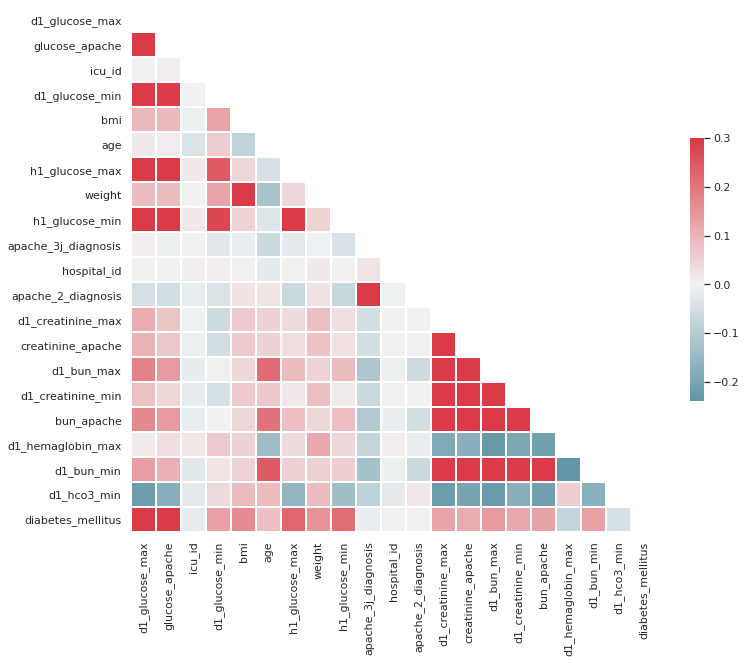

In [115]:
list_for_correlations=top_features['Feature'].to_list()
list_for_correlations.append('diabetes_mellitus')
oc.correlations(train_df,list_for_correlations)

**Test Submission**

In [116]:
def Kaggle_submission(file_name,model,test_data,ids_list):
    if TARGET in test_data.columns:
        test_data.drop([TARGET],axis=1,inplace=True)
    #test_pred=model.predict(test_data[features])[:,1]
    test_pred=model.predict(test_data[features])
    print (test_pred[1:2])

    submit=pd.DataFrame()
    submit['encounter_id'] = ids_list
    submit['diabetes_mellitus'] = test_pred
    submit.to_csv(file_name,index=False)
    return submit
    

In [117]:
categorical_features=[]
for c in test_df.columns:
    col_type = train_df[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        test_df[c] = test_df[c].astype('category')
        categorical_features.append(c)
print (categorical_features)

TARGET="diabetes_mellitus"
submit=Kaggle_submission("LGBM_baseline_v14.csv",clf,test_df,test_df['encounter_id'].tolist())

['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'icu_type']
[0.42415182]


In [118]:
submit.head(20)

,encounter_id,diabetes_mellitus
0,144740,0.086166
1,141990,0.424152
2,142038,0.342457
3,138628,0.152163
4,141682,0.514535
5,139096,0.131198
6,142994,0.862501
7,141954,0.120958
8,135344,0.819371
9,142552,0.924867


In [119]:
from google.colab import files
submit.to_csv('Diabaties_result.csv',index=False)
files.download('Diabaties_result.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>